In [5]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage import exposure
import skimage

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon



from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw


In [3]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'
denoised2_name='denoised2.png'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)
denoised2_pil=Image.open(denoised2_name)

image2=grainPreprocess.image_preprocess(grain2_pil)
image3=grainPreprocess.image_preprocess(grain3_pil)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:44: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(img)


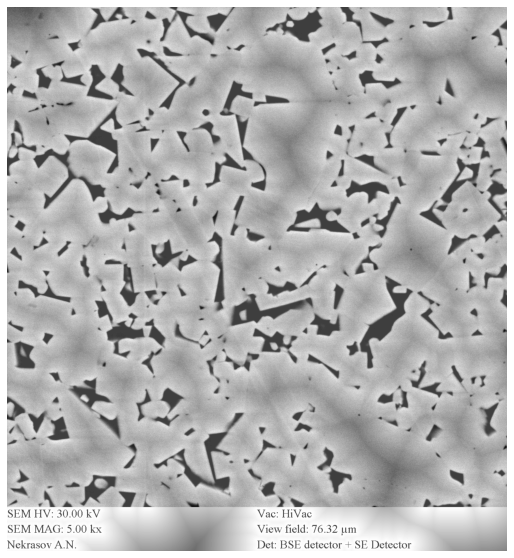

Lossy conversion from float64 to uint8. Range [173.27315120215476, 509.0]. Convert image to uint8 prior to saving to suppress this warning.


In [18]:
image=grainPreprocess.combine(grain2_pil,1)
img=255-edt(image)
grainShow.img_show(img+image,N=10,cmap='gray')
io.imsave('dist_inv+image.png',img+image)

In [ ]:
grainShow.img_show(img,N=10,cmap='gray')
io.imsave('lines.png',img)

In [5]:
img=cv2.drawContours( image, contours, -1, (110,0,0), 3, cv2.LINE_AA, hierarchy, 1 )# рисует на исходном изображении!!
io.imsave('draw contour.png',img)

In [6]:
def draw_edges(image,cnts,color=(50,50,50)):
    new_image=copy.copy(image)
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    
    for j,cnt in enumerate(cnts):
        if len(cnt)>1:
            point=cnt[0][0]
     #       print(point)
            x1,y1=point[1],point[0]
      #      print(x1)
      #      print(y1)
            x_start,y_start=point[1],point[0]
            r=6
     #       draw.ellipse((y1-r,x1-r,y1+r,x1+r), fill=color, width=10)
            coords = approximate_polygon(cnt[:,0], tolerance=3)
            for i,point2 in enumerate(coords):
                p2=point2
     #           print('point2',p2)
                x2,y2=p2[1],p2[0]
      #          print('x2',x2)
      #          print('y2',y2)
      #          draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=6)
                draw.line((y1,x1,y2,x2), fill=(100,100,100), width=6)
                x1,y1=x2,y2

     #       draw.line((y_start,x_start,y1,x1), fill=(100,100,100), width=6)
        else:
            continue

    img=np.array(im)

    return  img

In [4]:
edges = cv2.Canny(image2,0,255,L2gradient=False)
io.imsave('edges.png',edges)

In [26]:
image2=grainPreprocess.image_preprocess(grain2_pil)
image3=grainPreprocess.image_preprocess(grain3_pil)

#image=rgb2gray(np.array(grain2_pil))
#image=image2
image=rgb2gray(np.array(denoised2_pil))
#edges = cv2.Canny(image,0,255,L2gradient=False)
contours, hierarchy = cv2.findContours( image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
lines=draw_edges(image,contours)

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


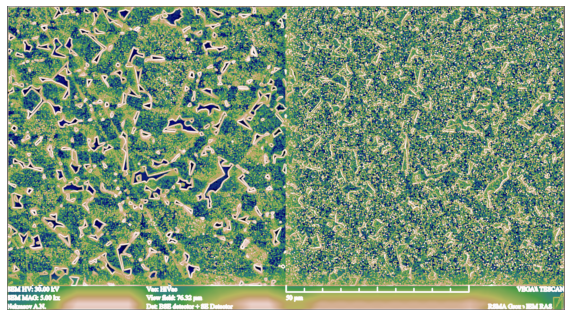

In [21]:
grainShow.img_show(lines,N=10,cmap='gray')
io.imsave('find contours3.png',lines)

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.
C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3331: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


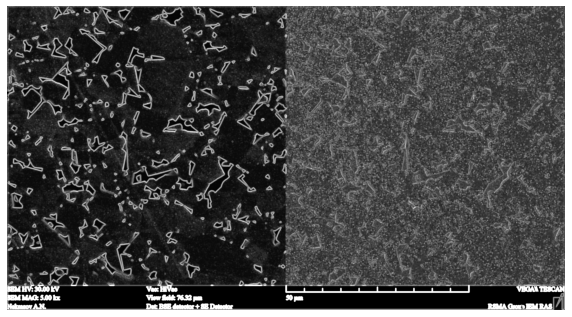

In [9]:
grad_input=rgb2gray(lines)
grad = abs(filters.rank.gradient(grad_input, disk(4))).astype('uint8')
grainShow.img_show(grad,N=10,cmap='gray')
io.imsave('grad4.png',grad)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


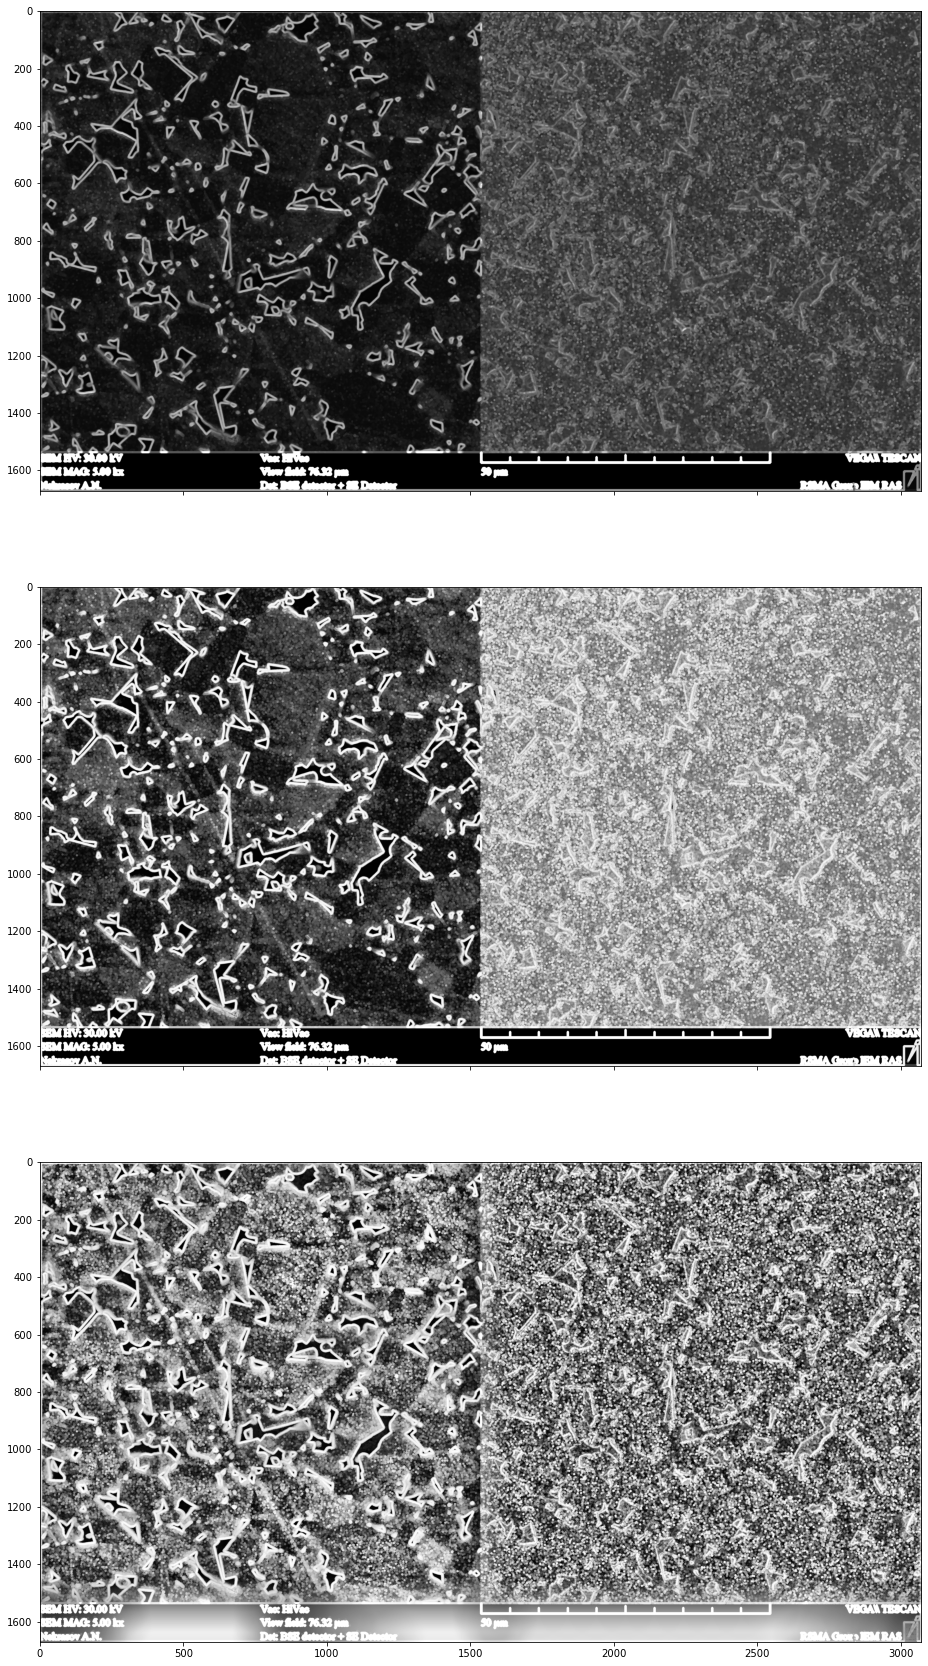

In [13]:
image =grad
# denoise image
denoised1 = filters.rank.median(image, disk(3))
denoised2 = exposure.equalize_hist(image/255)
denoised3 =  filters.rank.equalize(image, disk(100))
denoised4 = filters.rank.autolevel_percentile(image, selem=disk(20), p0=.2, p1=.7)

N=30

fig, axes = plt.subplots( nrows=3, figsize=(N, N),
                         sharex=True, sharey=True)
ax = axes.ravel()


ax[0].imshow(denoised1, cmap=plt.cm.gray)
ax[1].imshow(denoised2, cmap=plt.cm.gray)
ax[2].imshow(denoised3, cmap=plt.cm.gray)

io.imsave('denoised1.png',denoised1)
io.imsave('denoised2.png',denoised2)
io.imsave('denoised3.png',denoised3)




plt.show()